In [ ]:
!pip install opencv-python

In [ ]:
!pip install scikit-image

In [ ]:
import numpy as np
import os
import cv2 as cv
import skimage.io
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from helpers import create_folder, masks_to_submission

In [8]:
images_path = '../experiments/R_K/results'

In [9]:
# Connected-components approach
def remove_isolated_pixels(image):
    # Pixel connectivity (4 for borders connections only, 8 for borders and edges connections)
    connectivity = 8
    
    output = cv.connectedComponentsWithStats(image, connectivity, cv.CV_32S)

    num_stats = output[0]
    labels = output[1]
    stats = output[2]

    new_image = image.copy()

    for label in range(num_stats):
        # The total area (in pixels) of the connected component is the last column of stats
        if stats[label,cv.CC_STAT_AREA] <= 200:
            # Areas of less than 200 "road" pixels are set to "foreground"
            new_image[labels == label] = 0
    
    return new_image

In [10]:
# Patches
def patc(image, pat):
    for a, j in enumerate(range(0, image.shape[1], 16)):  
            for b, i in enumerate(range(0, image.shape[0], 16)):  
                # Cut image in patches
                patch = image[i:i + 16, j:j + 16]
                m = np.mean(patch)
                if m > 0.25*255:
                    pat[i:i+16, j:j+16]=1
                else:
                    pat[i:i+16, j:j+16]=0
    return pat

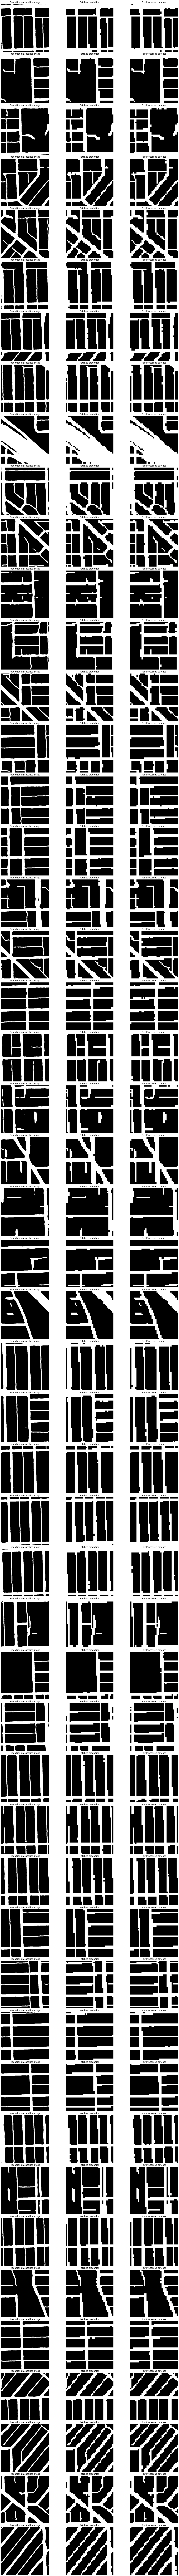

In [11]:
# Visualization on images patch-wise to see impact on patches
fig, ax = plt.subplots(50, 3, figsize = (15, 200), constrained_layout = True)
for i in range(0, 50):
    
    # TEST IMAGE
    name = os.path.join(images_path, 'satImage_{:03d}.png'.format(i+1))
    test_img = skimage.io.imread(name)
    ax[i, 0].imshow(test_img, cmap='gray')
    ax[i, 0].set_title('Prediction on satellite image')
    ax[i, 0].axis('off')
    
    # PATCHES
    pat=np.zeros((608,608))
    pat=patc(test_img, pat)
    ax[i,1].imshow(pat, cmap='gray')
    ax[i, 1].set_title('Patches prediction')
    ax[i, 1].axis('off')
        
    # POSTPROCESS
    # Connected components
    connected=remove_isolated_pixels(image=test_img)
    # Morphological closing operation : dilation followed by erosion
    closed = cv.morphologyEx(connected, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT, (2,2)))
    pat=np.zeros((608,608))
    pat=patc(closed, pat)
    ax[i,2].imshow(pat, cmap='gray')
    ax[i,2].set_title('PostProcessed patches')
    ax[i,2].axis('off')

plt.show()

In [12]:
# Submission

images = [os.path.join(images_path, 'satImage_{:03d}.png'.format(idx)) for idx in range(1,51)]
path_results = os.path.join(images_path, 'PostProcess')
create_folder(path_results)

# Postprocess and saves images
for index in range(len(images)):
    test_img = np.asarray(Image.open((images[index])))
    connected=remove_isolated_pixels(image=test_img)
    closed = cv.morphologyEx(connected, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT, (2,2))) 
    postprocess = Image.fromarray(closed)
    postprocess.save(os.path.join(path_results, 'satImage_{:03d}.png'.format(index+1)))
    
# Converts the saved masks to a submission file
submission_filename = os.path.join(path_results, 'R_K_postprocess.csv')
image_filenames = []
for i in range(1, 51):
    image_filename = path_results + '/satImage_' + '%.3d' % i + '.png'
    print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)
print("Postprocessing completed and saved.")

Folder created: ../experiments/R_K/results\PostProcess
../experiments/R_K/results\PostProcess/satImage_001.png
../experiments/R_K/results\PostProcess/satImage_002.png
../experiments/R_K/results\PostProcess/satImage_003.png
../experiments/R_K/results\PostProcess/satImage_004.png
../experiments/R_K/results\PostProcess/satImage_005.png
../experiments/R_K/results\PostProcess/satImage_006.png
../experiments/R_K/results\PostProcess/satImage_007.png
../experiments/R_K/results\PostProcess/satImage_008.png
../experiments/R_K/results\PostProcess/satImage_009.png
../experiments/R_K/results\PostProcess/satImage_010.png
../experiments/R_K/results\PostProcess/satImage_011.png
../experiments/R_K/results\PostProcess/satImage_012.png
../experiments/R_K/results\PostProcess/satImage_013.png
../experiments/R_K/results\PostProcess/satImage_014.png
../experiments/R_K/results\PostProcess/satImage_015.png
../experiments/R_K/results\PostProcess/satImage_016.png
../experiments/R_K/results\PostProcess/satImage_0

In [13]:
# Submissions csv comparison
before = pd.read_csv('../experiments/R_K/results/R_K.csv')
after = pd.read_csv('../experiments/R_K/results/PostProcess/R_K_postprocess.csv')
diff = (before.prediction - after.prediction).abs().sum()
print("There are {} different rows compared to before the postprocessing.".format(diff))

There are 1072 different rows compared to before the postprocessing.


This submission led to a test F1-score of 0.911, so less than the score of 0.913 obtained without postprocessing.  
More work needs to be done to find a correct way to postprocess, by tuning the morphological operations to apply and the kernels to use.